In [1]:
# import modules
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Helper Functions

In [2]:
def select_row_from_dataframe(dataframe:pd.DataFrame, row:int)->pd.DataFrame:
    """Select single row from dataframe for model explainability given a row number."""
    return dataframe.iloc[np.arange(row,row+1),:]

def select_id_from_dataframe(dataframe:pd.DataFrame, id:int)->pd.DataFrame:
    """Select single row from dataframe for model explainability given a particular ID"""
    return dataframe.loc[dataframe['ID']==id,:]    

def get_sorted_shap_values(shap_values, order='descending')->np.array:
    """get sorted shap_values from shap values input. Sorted mean in descending order using the absolute value of shap values."""
    shap_values_sorted = [shap_values[0].values[ind] for ind in np.argsort(np.abs(shap_values[0].values), kind='stable')]
    if order == 'ascending':
        return shap_values_sorted
    elif order == 'descending':
        return shap_values_sorted[::-1]
    else:
        print('check order specification')

def get_sorted_features_from_shap_values(shap_values, order='descending')->list:
    """get sorted feature names from shap values input. Sorted mean in descending order using the absolute shap values."""
    feature_names_sorted = [shap_values.feature_names[feature_ind] for feature_ind in np.argsort(np.abs(shap_values[0].values), kind='stable')]
    if order == 'ascending':
        return feature_names_sorted
    elif order == 'descending':
        return feature_names_sorted[::-1]
    else:
        print('check order specification')

def get_shap_values_list(pipeline, feature_names, dataframe:pd.DataFrame, row_selected:pd.DataFrame, number_random_samples:int=20)->list:
    """Get a list of shap values by randomly drawing samples from the input dataframe and calculating shap values for a single data row.
        It is assumed that the trained pipeline is inputted with the model being accessable using pipeline['rfe] and the data transformation
        being accessable using pipeline['preprocessor'].transform(data). Also provide a list of the feature names outputted by the pipeline."""
    shap_values_list = [] # collect n shap values for calculating the mean and standard deviation
    for n in range(number_random_samples):
        # get data sample
        data = dataframe.sample(100) 
        # init shap explainer
        explainer = shap.explainers.Permutation(model=pipeline['rfe'].predict,
                                                masker=pipeline['preprocessor'].transform(data), 
                                                feature_names=feature_names,
                                                max_evals=1000)
        # calculate shapley values
        shap_values = explainer(pipeline['preprocessor'].transform(row_selected))
        shap_values_list.append(shap_values)
    return shap_values_list        

def get_mean_from_shap_value_list(shap_values_list):
    return np.array([shap_values_list[n][0].values for n in range(len(shap_values_list))]).mean(axis=0)

def get_sd_from_shap_value_list(shap_values_list):
    return np.array([shap_values_list[n][0].values for n in range(len(shap_values_list))]).std(axis=0)        

def get_sorted_mean_shap_values(shap_values_list:list, order='descending')->np.array:
    """Get sorted shap_values inputing the shap_value_list from the method "get_shap_values_list". 
        Sorted mean in descending order using the absolute value of shap values.
        The sorted mean and the sorted standard deviation are returned """
    # calculate mean values and standard deviation
    shap_values_mean = get_mean_from_shap_value_list(shap_values_list)
    shap_values_sd = get_sd_from_shap_value_list(shap_values_list)
    # sorte shap values 
    shap_values_mean_sorted = [shap_values_mean[ind] for ind in np.argsort(np.abs(shap_values_mean), kind='stable')]
    shap_values_sd_sorted = [shap_values_sd[ind] for ind in np.argsort(np.abs(shap_values_mean), kind='stable')]
    if order == 'ascending':
        return shap_values_mean_sorted, shap_values_sd_sorted
    elif order == 'descending':
        return shap_values_mean_sorted[::-1], shap_values_sd_sorted[::-1]
    else:
        print('check order specification')

def get_sorted_features_from_mean_shap_values(shap_values_list:list, order='descending')->np.array:
    """get sorted feature names inputing the shap_value_list from the method "get_shap_values_list"."""
    # calculate mean values and standard deviation
    shap_values_mean = get_mean_from_shap_value_list(shap_values_list)
    # sort the feature names
    feature_names_sorted = [shap_values_list[0].feature_names[feature_ind] for feature_ind in np.argsort(np.abs(shap_values_mean), kind='stable')]
    if order == 'ascending':
        return feature_names_sorted
    elif order == 'descending':
        return feature_names_sorted[::-1]
    else:
        print('check order specification')

In [3]:
# set paths
DATAPATH = "./data"
DATAPROCESSEDPATH = "./data_preprocessed"
MODELPATH = "./models"

In [4]:
# load training dataset
with open(DATAPROCESSEDPATH + '/data_preprocessed.pkl','rb') as f:
    df = joblib.load(f)

df.head()    

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,Neg_ammortization,interest_only,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,116500,not_neg,not_int,1740.0,EXP,758,CIB,25-34,to_inst,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,b/c,206500,not_neg,not_int,4980.0,EQUI,552,EXP,55-64,to_inst,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nob/c,406500,neg_amm,not_int,9480.0,EXP,834,CIB,35-44,to_inst,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nob/c,456500,not_neg,not_int,11880.0,EXP,587,CIB,45-54,not_inst,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nob/c,296500,not_neg,not_int,10440.0,CRIF,602,EXP,25-34,not_inst,North,0


In [5]:
# seperate into numerical and categorical features
num_features = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index[2:-1])
cat_features = list(df.dtypes[df.dtypes == 'object'].index)
label = ['Status']
print('-----------------------------------')
print('numeric features: \n', num_features)
print('-----------------------------------')
print('categorical features: \n', cat_features)

-----------------------------------
numeric features: 
 ['loan_amount', 'income', 'Credit_Score']
-----------------------------------
categorical features: 
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']


In [6]:
# Separate into train and test sets
X = df[num_features + cat_features]
y = df[label].values.reshape(-1)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.3, stratify=y, random_state=123)

# Make Pipeline

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay


from lightgbm import LGBMClassifier



In [8]:
# choose classifier
classifier = LGBMClassifier(random_state=123)

In [9]:
rfe = RFECV(estimator=classifier,
            step=1,
            cv=StratifiedKFold(3),
            scoring=make_scorer(roc_auc_score),
            min_features_to_select=1)


In [10]:
# setup the pipeline elements
numeric_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                                    ('scaler', MinMaxScaler())
                                     ]
                               )
                               
categorical_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('onehotencode', OneHotEncoder(handle_unknown='error', drop='first', sparse=True))
                                          ]
                                    )

In [11]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numeric_transformer, num_features), 
                                               ('cat', categorical_transformer, cat_features)
                                              ], remainder='drop'
                                 )

In [12]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('rfe', rfe)
                          ]
                    )

In [13]:
# fit the pipeline 
pipe = pipeline.fit(X_train, y_train)
print (pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amount', 'income',
                                                   'Credit_Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencode',
                                                                   OneHotEncoder(drop='first'))

Confusion Matrix:
 [[33374   235]
 [ 5601  5391]] 

Accuracy: 0.8691509158987467
Overall Precision: 0.9582296480625666
Overall Recall: 0.4904475982532751
AUC: 0.8425278365493786


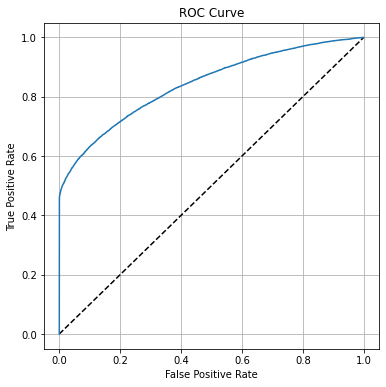

In [14]:
# Get predictions from test data
predictions = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid('on')
plt.show()

In [15]:
# Save the pipeline as a pickle file
filename = '/pipeline.pkl'
joblib.dump(pipe, MODELPATH + filename)

['./models/pipeline.pkl']

# Test Scoring New Data

In [16]:
# load training dataset
with open(DATAPROCESSEDPATH + '/data_preprocessed.pkl','rb') as f:
    df_new = joblib.load(f)

# select first row
df_new = df_new[0:1]
df_new.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,Neg_ammortization,interest_only,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,116500,not_neg,not_int,1740.0,EXP,758,CIB,25-34,to_inst,south,1


In [17]:
# load pipeline
with open(MODELPATH + '/pipeline.pkl','rb') as f:
    pipe_loaded = joblib.load(f)

print(pipe_loaded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['loan_amount', 'income',
                                                   'Credit_Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencode',
                                                                   OneHotEncoder(drop='first'))

In [18]:
# seperate into numerical and categorical features
num_features = list(df_new.dtypes[(df_new.dtypes == 'int64') | (df_new.dtypes == 'float64')].index[2:-1])
cat_features = list(df_new.dtypes[df_new.dtypes == 'object'].index)
label = ['Status']
print('-----------------------------------')
print('numeric features: \n', num_features)
print('-----------------------------------')
print('categorical features: \n', cat_features)

-----------------------------------
numeric features: 
 ['loan_amount', 'income', 'Credit_Score']
-----------------------------------
categorical features: 
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']


In [19]:
# get feature array
X_new = df_new[num_features + cat_features]
X_new

,loan_amount,income,Credit_Score,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,Neg_ammortization,interest_only,credit_type,co-applicant_credit_type,age,submission_of_application,Region
0,116500,1740.0,758,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,not_neg,not_int,EXP,CIB,25-34,to_inst,south


In [20]:
# make prediction
pipe_loaded.predict_proba(X_new)

array([[0.73866675, 0.26133325]])

# Model Explainability

In [21]:
import shap

In [22]:
# reduce data for better computational performance
data = df_test.sample(200)

In [23]:
# get transformed data
data_trans = pipeline['preprocessor'].transform(data)

In [24]:
# get model
model = pipeline['rfe']
model

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=123),
      scoring=make_scorer(roc_auc_score))

In [25]:

def get_categorical_feature_names_encoded(pipeline:Pipeline, hotencoding_label:str, categorical_feature_names:list):
    return list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps[hotencoding_label].get_feature_names_out(categorical_feature_names))

cat_features_enc = get_categorical_feature_names_encoded(pipeline, 'onehotencode', cat_features)
cat_features_enc

['loan_limit_ncf',
 'Gender_Joint',
 'Gender_Male',
 'Gender_Sex Not Available',
 'approv_in_adv_pre',
 'loan_type_type2',
 'loan_type_type3',
 'loan_purpose_p2',
 'loan_purpose_p3',
 'loan_purpose_p4',
 'Credit_Worthiness_l2',
 'business_or_commercial_nob/c',
 'Neg_ammortization_not_neg',
 'interest_only_not_int',
 'credit_type_CRIF',
 'credit_type_EQUI',
 'credit_type_EXP',
 'co-applicant_credit_type_EXP',
 'age_35-44',
 'age_45-54',
 'age_55-64',
 'age_65-74',
 'age_<25',
 'age_>74',
 'submission_of_application_to_inst',
 'Region_North-East',
 'Region_central',
 'Region_south']

In [26]:
# feature names
feature_names = num_features + cat_features_enc
feature_names

['loan_amount',
 'income',
 'Credit_Score',
 'loan_limit_ncf',
 'Gender_Joint',
 'Gender_Male',
 'Gender_Sex Not Available',
 'approv_in_adv_pre',
 'loan_type_type2',
 'loan_type_type3',
 'loan_purpose_p2',
 'loan_purpose_p3',
 'loan_purpose_p4',
 'Credit_Worthiness_l2',
 'business_or_commercial_nob/c',
 'Neg_ammortization_not_neg',
 'interest_only_not_int',
 'credit_type_CRIF',
 'credit_type_EQUI',
 'credit_type_EXP',
 'co-applicant_credit_type_EXP',
 'age_35-44',
 'age_45-54',
 'age_55-64',
 'age_65-74',
 'age_<25',
 'age_>74',
 'submission_of_application_to_inst',
 'Region_North-East',
 'Region_central',
 'Region_south']

In [27]:
relevant_features = model.get_feature_names_out(feature_names)
relevant_features

array(['loan_amount', 'income', 'Credit_Score', 'loan_limit_ncf',
       'Gender_Joint', 'approv_in_adv_pre', 'loan_type_type2',
       'loan_type_type3', 'loan_purpose_p3', 'loan_purpose_p4',
       'Credit_Worthiness_l2', 'Neg_ammortization_not_neg',
       'interest_only_not_int', 'credit_type_EQUI',
       'co-applicant_credit_type_EXP', 'age_65-74',
       'submission_of_application_to_inst', 'Region_south'], dtype=object)

In [28]:
# init shap explainer
explainer = shap.explainers.Permutation(model=model.predict,
                                        masker=data_trans, 
                                        feature_names=feature_names,
                                        max_evals=1000)
# calculate shapley values
shap_values = explainer(data_trans)

Permutation explainer: 201it [00:51,  3.55it/s]                         


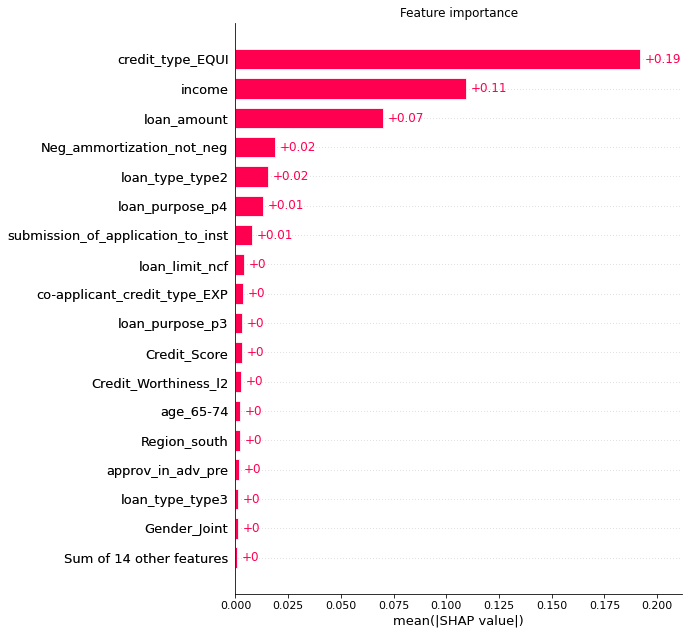

In [29]:
# bar plot 
shap.plots.bar(shap_values,
                max_display=len(relevant_features),
                show=False)
fig = plt.gcf()
ax = plt.gca()
ax.set_title('Feature importance')
plt.show()

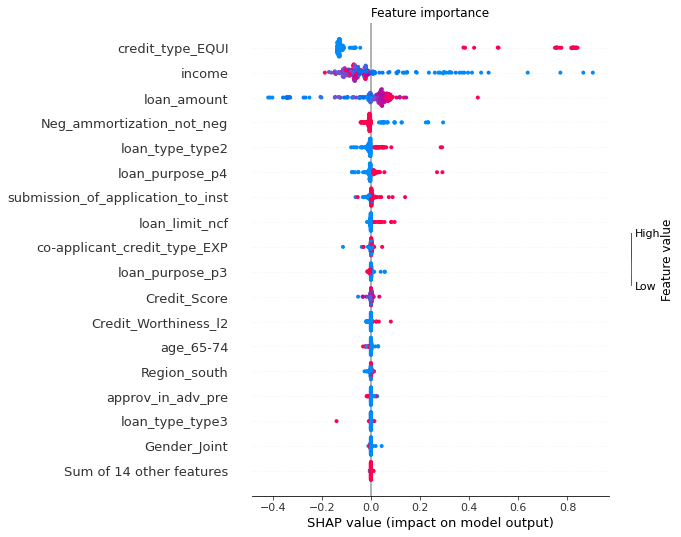

In [30]:
# beeswarm plot 
shap.plots.beeswarm(shap_values,
                    max_display=len(relevant_features), 
                    show=False)
fig = plt.gcf()
ax = plt.gca()
ax.set_title('Feature importance')
plt.show()

# Local Model Explanation

In [31]:
df_test.head(3)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,Neg_ammortization,interest_only,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
91689,116579,2019,ncf,Female,nopre,type1,p4,l1,nob/c,336500,not_neg,not_int,6840.0,CIB,829,EXP,35-44,not_inst,south,0
48375,73265,2019,cf,Female,pre,type1,p1,l1,nob/c,356500,not_neg,int_only,4080.0,EXP,732,CIB,65-74,to_inst,south,0
22903,47793,2019,ncf,Female,nopre,type1,p4,l1,nob/c,346500,not_neg,not_int,12480.0,CIB,825,CIB,55-64,to_inst,North,0


In [32]:
row = 5 # define row to be explained
row_selected = select_row_from_dataframe(df_test, row=row)

# get data sample
data = df_test.sample(1000) 
# init shap explainer
explainer = shap.explainers.Permutation(model=pipeline['rfe'].predict,
                                        masker=pipeline['preprocessor'].transform(data), 
                                        feature_names=feature_names,
                                        max_evals=1000)
# calculate shapley values
shap_values = explainer(pipeline['preprocessor'].transform(row_selected))

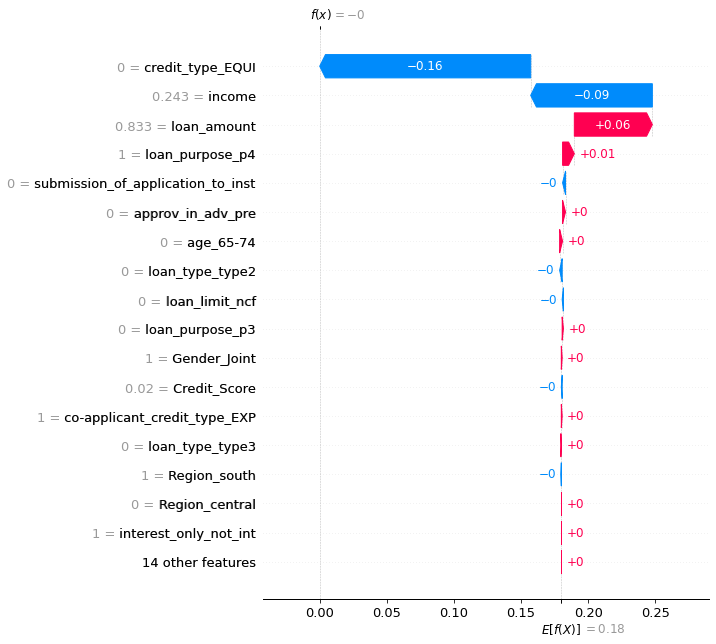

In [33]:
# bar plot 
shap.plots.waterfall(shap_values[0],
                    max_display=len(relevant_features))

In [34]:
order='descending'
feature_names_sorted = get_sorted_features_from_shap_values(shap_values, order=order)
shap_values_sorted = get_sorted_shap_values(shap_values, order=order)

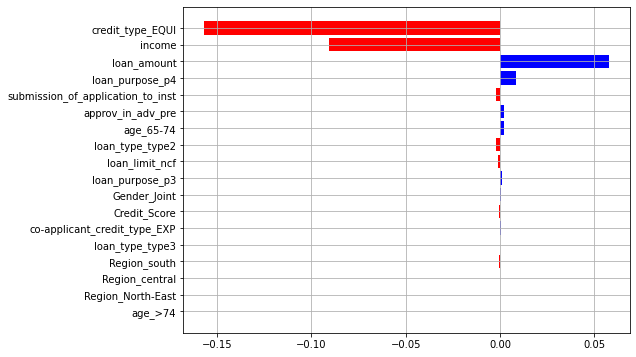

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
y = feature_names_sorted[0:len(relevant_features)][::-1]
width = shap_values_sorted[0:len(relevant_features)][::-1]
colors = ['b' if e >= 0 else 'r' for e in shap_values_sorted[0:len(relevant_features)][::-1]]
ax.barh(y=y, 
        width=width,
        color=colors)
ax.grid()
plt.show()

# Considere the Variance in the shap values! do mean and sd stuff

In [45]:
df_test['ID'].values

array([116579,  73265,  47793, ..., 124553, 159487, 129244], dtype=int64)

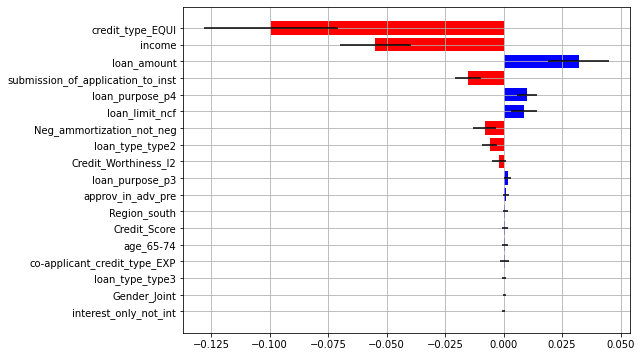

In [49]:
#row_selected = select_row_from_dataframe(df_test, row=5)
row_selected = select_id_from_dataframe(df_test, id=116579)

# generate list of shap values using random data samples
shap_values_list = get_shap_values_list(pipeline, feature_names, df_test, row_selected, 50)

# sort mean and sd and feature names
shap_values_mean_sorted, shap_values_sd_sorted = get_sorted_mean_shap_values(shap_values_list)
feature_names_sorted = get_sorted_features_from_mean_shap_values(shap_values_list)


fig, ax = plt.subplots(1,1,figsize=(8,6))
y = feature_names_sorted[0:len(relevant_features)][::-1]
x = shap_values_mean_sorted[0:len(relevant_features)][::-1]
xerr=shap_values_sd_sorted[0:len(relevant_features)][::-1]
colors = ['b' if e >= 0 else 'r' for e in shap_values_mean_sorted[0:len(relevant_features)][::-1]]
ax.barh(y=y, 
        width=x,
        xerr=xerr,
        color=colors)
ax.grid()
plt.show()